# Getting Data

First: Get some dog images

In [1]:
# Get the 2000 dogs and cats from the Google ML Practicum for Image Classification
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-04-21 22:46:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  36.3MB/s    in 1.8s    

2022-04-21 22:46:16 (36.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
import shutil

The next cell is getting folders ready for data, separated out for ease of testing the data sorting and file moving. Can only be run once.

In [ ]:
os.mkdir('our_data')
os.mkdir('our_data/train')
os.mkdir('our_data/train/dogs')
os.mkdir('our_data/validation')
os.mkdir('our_data/validation/dogs')

os.mkdir('our_data/train/coyotes')
os.mkdir('our_data/validation/coyotes')

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dogs_dir = os.path.join(base_dir, 'train/dogs/')
validate_dogs_dir = os.path.join(base_dir, 'validation/dogs/')

files = os.listdir(train_dogs_dir)
destTrainDogs = 'our_data/train/dogs/'
for f in files:
  src = train_dogs_dir + f
  dest = destTrainDogs + f
  shutil.move(src,dest)

files = os.listdir(validate_dogs_dir)
destValidateDogs = 'our_data/validation/dogs/'
for f in files:
  src = validate_dogs_dir + f
  dest = destValidateDogs + f
  shutil.move(src,dest)  

In [ ]:
# Test the above worked
print(len(os.listdir('our_data/train/dogs')), " Dog training images")
print(len(os.listdir('our_data/validation/dogs')), " Dog validation images")

1000  Dog training images
500  Dog validation images


Looks like we have 1500 images of dogs, divided up into 2/3rds training 1/3rd validation

Now get some Coyote images.

Just over 900 coyote images were provided by Prof. Brenden. Those are hosted in our github which I'm then downloading here.

In [ ]:
# Now try to get the coyotes zip 
!wget https://github.com/Dylan-Riley/AD470_Team4/blob/main/coyotes.zip?raw=true -O coyotes.zip

--2022-04-19 22:14:42--  https://github.com/Dylan-Riley/AD470_Team4/blob/main/coyotes.zip?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Dylan-Riley/AD470_Team4/raw/main/coyotes.zip [following]
--2022-04-19 22:14:42--  https://github.com/Dylan-Riley/AD470_Team4/raw/main/coyotes.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dylan-Riley/AD470_Team4/main/coyotes.zip [following]
--2022-04-19 22:14:42--  https://raw.githubusercontent.com/Dylan-Riley/AD470_Team4/main/coyotes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

Then we need the data to be workable, so following the example set by the Google Developers Machine Learning Practicum on Image Classification I've split the data up into training and validation sets, roughly four training to one validation.

In [ ]:
local_zip = '/content/coyotes.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

path = 'coyotes/'
moveToTrain = 'our_data/train/coyotes/'
moveToValidate = 'our_data/validation/coyotes/'
i = 0
files = os.listdir(path)
for f in files:
  src = path + f
  if i % 4 == 0:
    dest = moveToValidate + f
  else:
    dest = moveToTrain + f
  shutil.move(src,dest)
  i += 1

In [ ]:
print(len(os.listdir('our_data/train/coyotes')), " Coyotes training data")
print(len(os.listdir('our_data/validation/coyotes')), " Coyotes validation data")

693  Coyotes training data
232  Coyotes validation data


Or 695 training coyotes, and 232 validatation coyotes

# Data Augmentation

Here we're using some of image processing functions included in the ImageDataGenerator to manipulate the images between each epoch so the model gets a "fresh" set of images every time

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
trainDatagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# No augmentation on validation data
validateDatagen = ImageDataGenerator( rescale = 1./255 )

trainGenerator = trainDatagen.flow_from_directory(
    'our_data/train',
    target_size = (150,150),
    batch_size = 16,
    class_mode = 'binary'
)

validationGenerator = validateDatagen.flow_from_directory(
    'our_data/validation',
    target_size = (150,150),
    batch_size = 7,
    class_mode = 'binary'
)

Found 1692 images belonging to 2 classes.
Found 732 images belonging to 2 classes.


# Building the Model

Finally we can build the model. Using a configuration of convolution, relu, and maxpooling that's commonly used for image classification we'll extract 16, then 32, then 64 convolutional filters. We have a similar data size to that Machine Learning practicum of about 1600 total images so we won't want to include more modules at a risk of overfitting.

Speaking of which, another step is taken in here to fight overfitting is including a dropout rate of 0.5 to randomly drop nodes of layer output.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
imgInput = layers.Input(shape = (150, 150, 3))

# First convolution
x = layers.Conv2D(16, 3, activation='relu')(imgInput)
x = layers.MaxPooling2D(2)(x)

# Second convolution
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)

# Add dropout to help fight overfitting
x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

# Configure model
model = Model(imgInput, output)
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.001), metrics=['acc'])

# Training the Model

It's finally time to train the model. I'm going to start with 20 epochs just to get done a little quicker.

In [ ]:
history = model.fit_generator(
    trainGenerator,
    steps_per_epoch = 100, # 16 batch size, approx 1600 images
    epochs = 20,
    validation_data = validationGenerator,
    validation_steps = 100, # 7 batch size, approx 700 images
    verbose = 2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
100/100 - 65s - loss: 0.6952 - acc: 0.6078 - val_loss: 0.5811 - val_acc: 0.7743 - 65s/epoch - 649ms/step
Epoch 2/20
100/100 - 59s - loss: 0.6070 - acc: 0.7005 - val_loss: 0.6054 - val_acc: 0.6286 - 59s/epoch - 589ms/step
Epoch 3/20
100/100 - 58s - loss: 0.5514 - acc: 0.7400 - val_loss: 0.4027 - val_acc: 0.8157 - 58s/epoch - 577ms/step
Epoch 4/20
100/100 - 58s - loss: 0.5401 - acc: 0.7475 - val_loss: 0.4049 - val_acc: 0.8357 - 58s/epoch - 576ms/step
Epoch 5/20
100/100 - 58s - loss: 0.5492 - acc: 0.7538 - val_loss: 0.4789 - val_acc: 0.7771 - 58s/epoch - 578ms/step
Epoch 6/20
100/100 - 57s - loss: 0.5107 - acc: 0.7763 - val_loss: 0.4353 - val_acc: 0.7957 - 57s/epoch - 575ms/step
Epoch 7/20
100/100 - 58s - loss: 0.5138 - acc: 0.7782 - val_loss: 0.3793 - val_acc: 0.8429 - 58s/epoch - 577ms/step
Epoch 8/20
100/100 - 58s - loss: 0.4986 - acc: 0.7845 - val_loss: 0.3436 - val_acc: 0.8657 - 58s/epoch - 577ms/step
Epoch 9/20
100/100 - 58s - loss: 0.4563 - acc: 0.8020 - val_loss: 1.0836

# Evaluating the Model

Text(0.5, 1.0, 'Training and Validation loss')

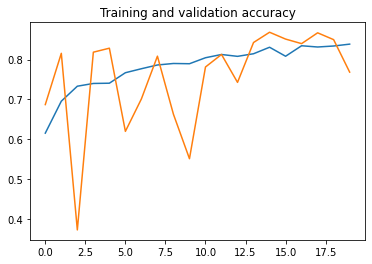

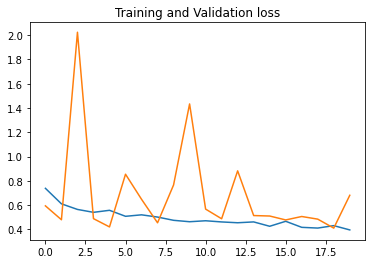

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and validation accuracy")

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation loss")

We're getting up to about 85% accuracy and pretty low loss. Maybe with more epochs it will be better, but it already took twenty minutes to run the 20. Really what would improve this model a lot more would be *a lot* more data. The original Kaggle dataset has 25,000 images of cats and dogs while we used just 1500 dogs -- 1000 to train on -- and 900 pictures of coyotes -- **only 600** to train on.

But if those "found dog" posts on Facebook are anything to go by we might already be better than the average person at telling coyotes from dogs.